1. Random Variables
2. Sampling Distributions
3. One Sample Confidence Intervals
4. One Sample Significance Tests
5. Two sample inference for the difference between groups
6. Inference for categorical data


In [4]:
# data manipulation # data  
import numpy as np
import pandas as pd
import calendar
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import datetime as dt
import folium
from folium import plugins
print(folium.__version__)

from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame\

# pandas display data frames as tables
from IPython.display import display, HTML

0.6.0


### Load the Divvy Data set

In [5]:
#parse_dates = true to read dates automatically
divvyTrips =pd.read_csv('Social_Economic_Info_By_Zipcode/MergedData/divvy_trips_zipcode_stationdistance.csv',parse_dates=True)

#Ensure the dataframe has no duplicates
divvyTrips = divvyTrips.drop_duplicates()

#Drop unnamed columns
divvyTrips.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

#Add start and stop dates
divvyTrips.starttime = pd.to_datetime(divvyTrips.starttime)
divvyTrips.stoptime = pd.to_datetime(divvyTrips.starttime)

divvyTrips['startdate'] = divvyTrips.starttime.dt.date
divvyTrips['stopdate'] = divvyTrips.stoptime.dt.date


# Missing Values

Let's analyze missing values further below

1. gender                       3756910
2. latitude_start                  1153
3. longitude_start                 1153
4. dpcapacity_start                1153
5. latitude_end                    1180
6. longitude_end                   1180
7. dpcapacity_end                  1180
8. humidity                         920
9. zipcode_start                4302474
10. zipcode_end                  4283942
11. start_station                6754541
12. end_station                  6754541
13. distance_in_meters           6920850
14. city                        11765376
15. station_start               11765376
16. station_end                 11765376
17. distance_meters_by_coord    11765376
18. station_start_latitude      11765376
19. station_start_longitude     11765376
20. station_end_latitude        11765376
21. station_end_longitude       11765376
22. start_station_group             1153
23. end_station_group               1180
</li>

In [6]:
#Drop the following columns, they are redundant and bear no meaning for analysis
divvyTrips.drop(['city'     
,'station_start_latitude'      
,'station_start_longitude'     
,'station_end_latitude'     
,'station_end_longitude'
,'start_station'
,'start_station'
],axis=1,inplace=True)   

In [7]:
#Divvy does not descrive what dependent usertype is. Here we are interested only in usertypes -
#customer and subscriber
divvyTrips = divvyTrips[divvyTrips.usertype != 'Dependent']
divvyTrips.groupby('usertype')['trip_id'].agg(len)

usertype
Customer       3756882
Subscriber    10017582
Name: trip_id, dtype: int64

In [8]:
#Gender Column - All the customers have an empty gender field. 
#We can assume that if the gender is empty the usertype is customer
divvyTrips.loc[divvyTrips['gender'].isnull(),['usertype']].groupby('usertype').size()

usertype
Customer      3755542
Subscriber       1368
dtype: int64

In [9]:
divvyTrips.loc[(divvyTrips['gender'].isnull()) &(divvyTrips['usertype'] == 'Subscriber'),['usertype']]= 'Customer'

divvyTrips.loc[divvyTrips['gender'].isnull(),['usertype']].groupby('usertype').size()

usertype
Customer    3756910
dtype: int64

In [10]:
#Station Capacity is missing for certain stations, lets keep rows with dock capacities
divvyTrips = divvyTrips[np.isfinite(divvyTrips['dpcapacity_end'])]
divvyTrips = divvyTrips[np.isfinite(divvyTrips['dpcapacity_start'])]

divvyTrips[divvyTrips.dpcapacity_end.isnull()]
divvyTrips[divvyTrips.dpcapacity_start.isnull()]

,trip_id,usertype,gender,starttime,stoptime,tripduration,from_station_id,from_station_name,latitude_start,longitude_start,...,months-year,tripInMinutes,start_station_group,end_station_group,revenue,Hour,TypeOfDay,season,startdate,stopdate


In [11]:
#Handle missing values for zipcodes, station source and destination and distance from and to station
divvyTrips['zipcode_start'].isnull().fillna(value=0,inplace=True)
divvyTrips['zipcode_end'].isnull().fillna(value=0,inplace=True)
divvyTrips['distance_in_meters'].isnull().fillna(value=0.0,inplace=True)

In [181]:
#Year 2013 has 6 months of data since Divvy was launched. Let's remove this data now
divvyTrips = divvyTrips[divvyTrips.Year != 2013]

In [1]:
##Weather Data Error Codes correction

In [12]:
weatherdf = divvyTrips[['trip_id'
,"tripInMinutes"
,'startdate'
,'Month'
,'month_name'
,'months-year'
,'Year'
,'temperature'
,'windchill'
,'dewpoint'
,'humidity'
,'pressure'
,'visibility'
,'wind_speed'
,'precipitation'
,'events'
,'rain'
,'conditions'
]].copy()

weatherdf = weatherdf[(weatherdf['temperature'] > -25)
& (weatherdf['windchill'] > -25)   
& (weatherdf['dewpoint'] > -25)
& (weatherdf['humidity'] > -25)
& (weatherdf['pressure'] > -25)
& (weatherdf['visibility'] > -25)   
& (weatherdf['wind_speed'] > -25)   
& (weatherdf['precipitation'] > -25)
& (weatherdf['rain'] > -25)
]


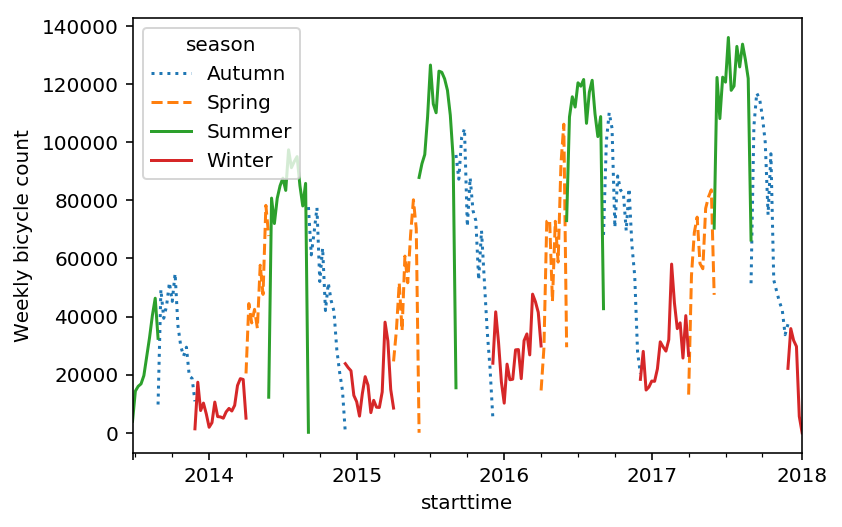

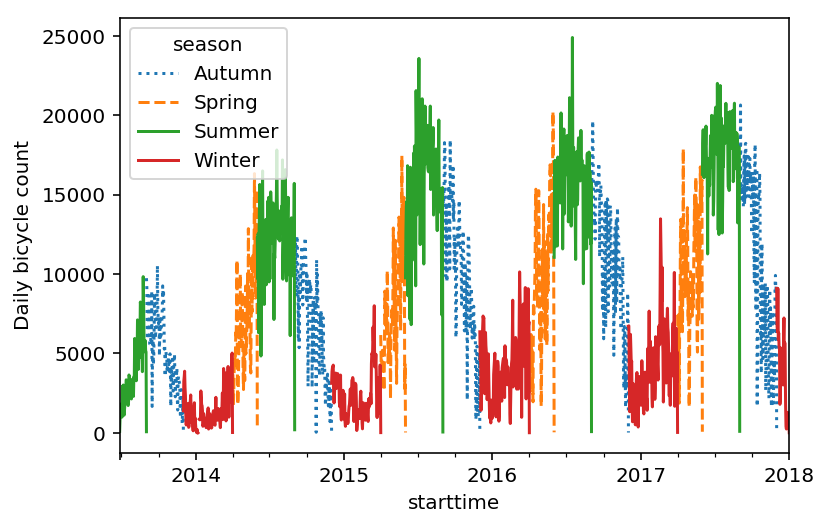

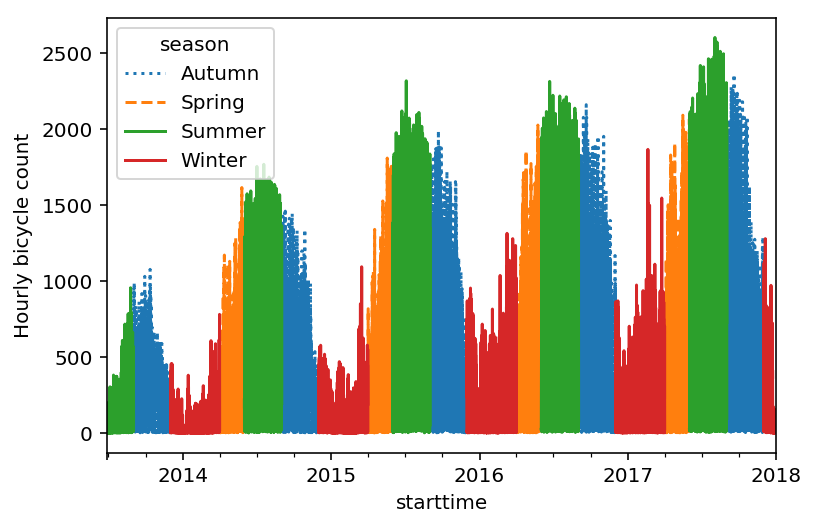

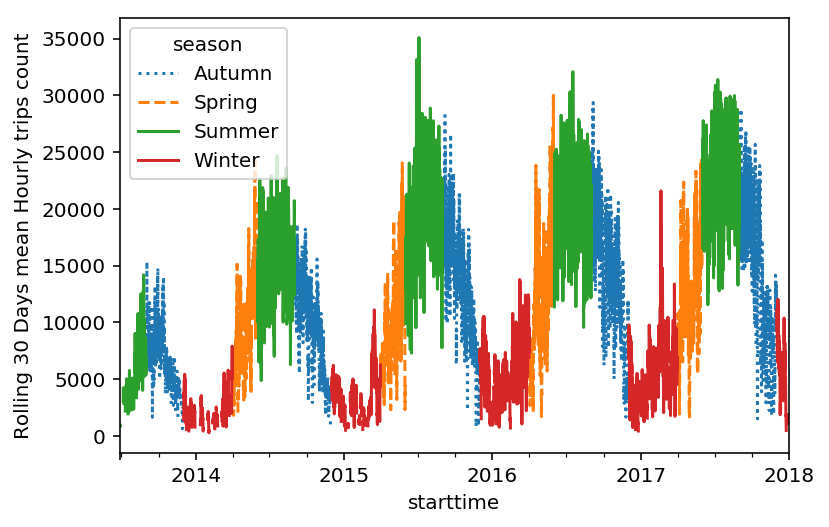

In [144]:
tripsByTime = divvyTrips[['starttime','season','trip_id']]

#Keep the date and Hour in the datetime object
tripsByTime=tripsByTime.assign(starttime=tripsByTime.starttime.dt.round('H'))
#Method 2: tripsByTime['starttime'] = tripsByTime.assign(starttime=pd.to_datetime(tripsByTime.starttime.dt.date) +pd.to_timedelta(tripsByTime.starttime.dt.hour, unit='H')) 
#Method 3: df = df.assign(Date = lambda x: pd.to_datetime(x['Date'].dt.strftime('%Y-%m-%d %H')))

tripsByTime = tripsByTime.groupby(['starttime','season']).agg({"trip_id":"count"})
tripsByTime.reset_index(drop=False, inplace=True) # remove the 'day' as the index
tripsByTime.rename(columns={"trip_id":"tripCount"}, inplace=True) # The old index column didn't have a name - add "date" as name
tripsByTime =tripsByTime.pivot(index='starttime',columns='season',values='tripCount')

weekly = tripsByTime.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count');

daily = tripsByTime.resample('D').sum()
daily.plot(style=[':', '--', '-'])
plt.ylabel('Daily bicycle count');

hourly = tripsByTime.resample('H').sum()
hourly.plot(style=[':', '--', '-'])
plt.ylabel('Hourly bicycle count');

hourly = tripsByTime.resample('H').sum()
hourly.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('Rolling 30 Days mean Hourly trips count');

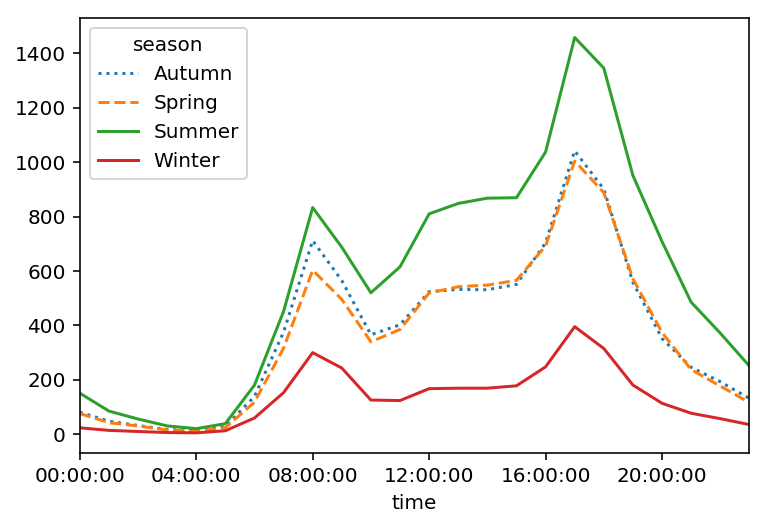

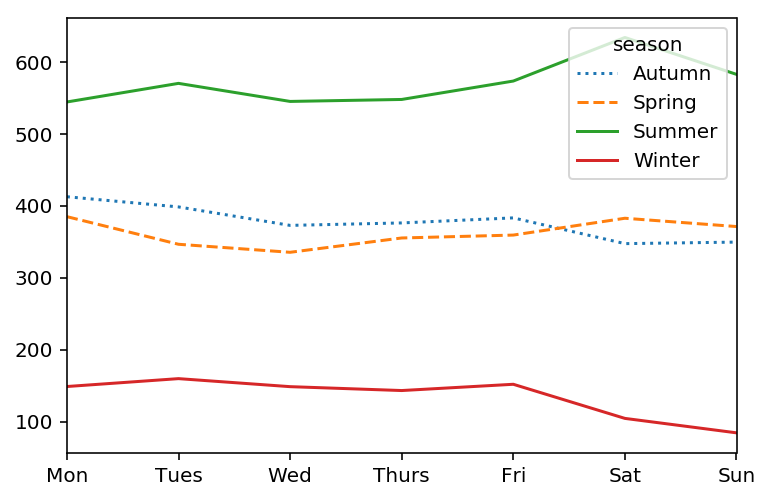

In [172]:


by_time = tripsByTime.groupby(tripsByTime.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

by_weekday = tripsByTime.groupby(tripsByTime.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);




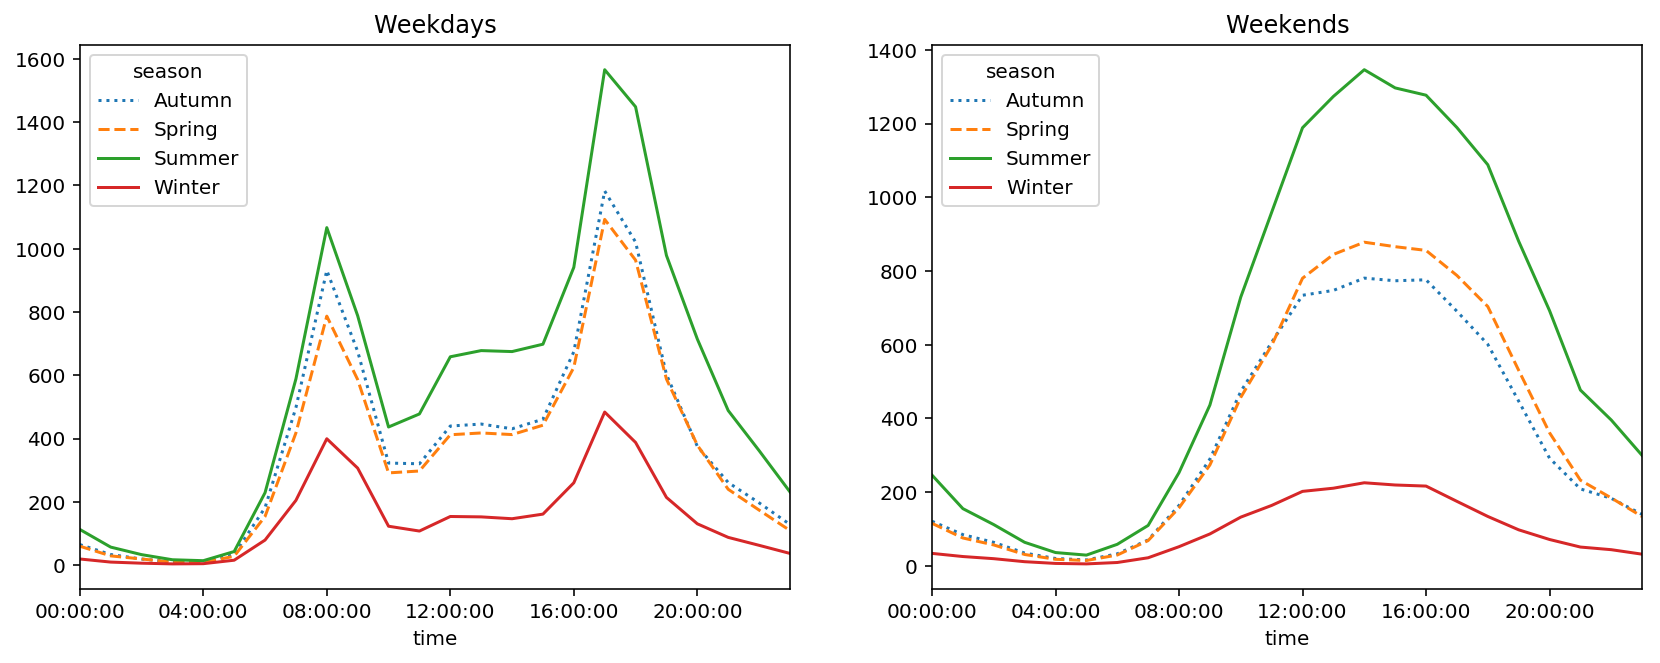

In [171]:
weekend = np.where(tripsByTime.index.weekday < 5, 'Weekday', 'Weekend')
by_time = tripsByTime.groupby([weekend, tripsByTime.index.time]).mean()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

## % of Bike rentals By Gender and Season

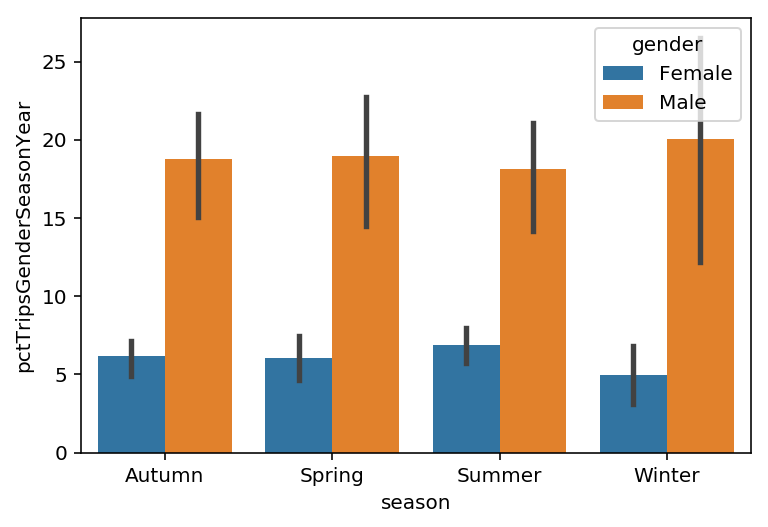

In [216]:
probDistByGender = divvyTrips.groupby(['gender','season','Year']).agg({
        "trip_id": "count" #Discrete Variable
        ,"tripInMinutes": "mean" #Continuous Variable 
        })    
# clean up the aggregated data to a more easily analysed set:
probDistByGender.reset_index(drop=False, inplace=True) # remove the 'day' as the index
probDistByGender.rename(columns={"trip_id":"tripCount"}, inplace=True) # The old index column didn't have a name - add "date" as name
#probDistByGender.columns = probDistByGender.columns.droplevel(level=0) # The aggregation left us with a multi-index

sumTripsByCat = probDistByGender.groupby(['season']).agg({
        "tripCount": "sum" #Discrete Variable
        ,"tripInMinutes": "mean" #Continuous Variable 
        }) 
# clean up the aggregated data to a more easily analysed set:
sumTripsByCat.reset_index(drop=False, inplace=True) # remove the 'day' as the index
sumTripsByCat.rename(columns={"tripCount":"totalTripsBySeasonYear","tripInMinutes":"totalDurationBySeasonYear"}, inplace=True) # The old index column didn't have a name - add "date" as name
#sumTripsByCat.columns = sumTripsByCat.columns.droplevel(level=0) # The aggregation left us with a multi-index

probDistByGender = probDistByGender.merge(sumTripsByCat, left_on=['season'], right_on=['season'], how='left')
probDistByGender['pctTripsGenderSeasonYear'] =  probDistByGender['tripCount']*100/probDistByGender['totalTripsBySeasonYear']
probDistByGender['pctDurationGenderSeasonYear'] =  probDistByGender['tripInMinutes']*100/probDistByGender['totalDurationBySeasonYear']

sns.barplot(data = probDistByGender, hue='gender',x='season',y='pctTripsGenderSeasonYear')
